In [14]:
from google.colab import drive
drive.mount('/content/drive')
dir_path = "/content/drive/MyDrive/crops"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from datetime import datetime
from tensorflow import keras 
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Activation, Dropout, Flatten, MaxPooling2D
from keras.losses import CategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from keras.applications.vgg19 import preprocess_input
#from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_resnet_v2 import preprocess_input
#from keras.applications.resnet import preprocess_input
from PIL import Image
from torchvision import transforms

In [16]:
# parameters for image data 

img_class_mode_ = 'categorical'
rotation_range_ = 15       # 15 degrees rotation range for image augmentation
width_shift_range_ = 0.15  # 15% horizontal shift range for image augmentation
height_shift_range_ = 0.15 # 15% pixels veritcal shift range for image augmentation
zoom_range_ = 0.3          # zoom range 0.7 - 1.3 for image augmentation
brightness_range_ = (0.3, 0.8)   # brightness range slight darkening or slight brightening (50% is no change) for image augmentation
horizontal_flip_ = True    # horizontal flip on for image augmentation
interpolation_mode_ = "lanczos"  # higher quality interpolation for re-scaling (when applicable)
fill_mode_ = "reflect"  # reflect margin for shifted regions for image augmentation
keep_aspect_ratio_ = True

In [17]:
# parameters for learning
img_batch_size_ = 32 
epochs_ = 150
checkpoint_path = "model_checkpoint_" + datetime.now().strftime('%Y%m%d-%H%M%S') + ".h5"
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [18]:
# load data and split into training and test/validation data sets
images_data = ImageDataGenerator(
    preprocessing_function = preprocess_input,  # Ref. https://keras.io/api/applications/vgg/#vgg19-function
    validation_split = 0.2,
    rotation_range = rotation_range_, width_shift_range = width_shift_range_,
    height_shift_range = height_shift_range_, zoom_range = zoom_range_,
    horizontal_flip = horizontal_flip_, fill_mode = fill_mode_, 
    brightness_range = brightness_range_)
trainD_shuffle = images_data.flow_from_directory(
    dir_path, shuffle = True, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'training')
trainD_noshuffle = images_data.flow_from_directory(
    dir_path, shuffle = False, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,    
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'training')
testD_noshuffle = images_data.flow_from_directory(
    dir_path, shuffle = False, target_size = (224, 224), interpolation = interpolation_mode_,
    keep_aspect_ratio = keep_aspect_ratio_,
    class_mode = img_class_mode_, batch_size = img_batch_size_, subset = 'validation')

Found 649 images belonging to 30 classes.
Found 649 images belonging to 30 classes.
Found 145 images belonging to 30 classes.


In [19]:
train_img_class_count = len(trainD_noshuffle.class_indices)
test_img_class_count = len(testD_noshuffle.class_indices)
if (train_img_class_count != test_img_class_count):
    raise Exception("Training and Testing Data Sets Not Aligned.")
img_class_count = test_img_class_count
print("image class count", img_class_count)

image class count 30


In [21]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.3 MB/s 


In [22]:
import efficientnet.keras as efn

In [23]:
# get pre-trained CNN
cnn = efn.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
cnn.trainable = False

16804768/16804768 [==============================] - 2s 0us/step


In [24]:
# build nerual network 
model = Sequential([
    cnn,
    Flatten(),
    Dense(500, activation = 'relu'), 
    # Dropout(0.4),
    Dense(250, activation = 'relu'), 
    # Dropout(0.3),
    # Dense(90, activation = 'relu'), 
    # Dropout(0.2),     
    Dense(img_class_count, activation = 'softmax')
])
model.compile(loss = CategoricalCrossentropy(), 
    optimizer=opt, 
     metrics = ['accuracy'])

In [25]:
# set up logging 
# and train nerual net

%load_ext tensorboard

log_dir = 'logs/batch/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/train'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir = log_dir)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, monitor="val_accuracy", batch_size = img_batch_size_,
    verbose=1, mode="max", save_weights_only=True, save_best_only=True)
history = model.fit(trainD_shuffle, epochs = epochs_, validation_data = testD_noshuffle, 
    callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/150
19/21 [==========================>...] - ETA: 30s - loss: 2.7169 - accuracy: 0.2895

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  warnings.warn(


21/21 [==============================] - ETA: 0s - loss: 2.6901 - accuracy: 0.2989 
Epoch 1: val_accuracy improved from -inf to 0.44828, saving model to model_checkpoint_20221205-025105.h5
21/21 [==============================] - 405s 19s/step - loss: 2.6901 - accuracy: 0.2989 - val_loss: 1.8739 - val_accuracy: 0.4483
Epoch 2/150
21/21 [==============================] - ETA: 0s - loss: 1.0946 - accuracy: 0.6826
Epoch 2: val_accuracy improved from 0.44828 to 0.59310, saving model to model_checkpoint_20221205-025105.h5
21/21 [==============================] - 20s 963ms/step - loss: 1.0946 - accuracy: 0.6826 - val_loss: 1.5030 - val_accuracy: 0.5931
Epoch 3/150
21/21 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.7997
Epoch 3: val_accuracy improved from 0.59310 to 0.65517, saving model to model_checkpoint_20221205-025105.h5
21/21 [==============================] - 20s 948ms/step - loss: 0.6735 - accuracy: 0.7997 - val_loss: 1.3697 - val_accuracy: 0.6552
Epoch 4/15

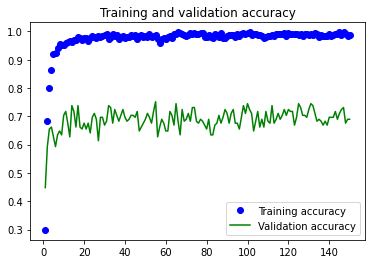

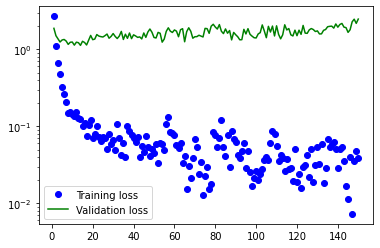

In [26]:
# CHANGE:  Plot training and validation accuracy over epochs
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label = "Training accuracy")
plt.plot(epochs, val_accuracy, "g", label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "g", label = "Validation loss")
plt.yscale("log")
plt.legend()
plt.show()

In [27]:
# restore checkpoint model
#model = keras.models.load_model(checkpoint_path)
model.load_weights(checkpoint_path)

In [28]:
# run prediction based on training data
train_scores = model.predict(trainD_noshuffle)
train_pred_labels = train_scores.argmax(axis = 1)

21/21 [==============================] - 17s 749ms/step


In [29]:
# evaluate trained network
print('')
print('')
print('Model Evaluation Using Training Data:')

print("Accuracy Score")
print(accuracy_score(trainD_noshuffle.labels, train_pred_labels))

print("Confusion Matrix")
print(confusion_matrix(trainD_noshuffle.labels, train_pred_labels))



Model Evaluation Using Training Data:
Accuracy Score
0.9907550077041603
Confusion Matrix
[[26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0 22  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  

In [30]:
# run prediction based on test data
test_scores = model.predict(testD_noshuffle)
test_pred_labels = test_scores.argmax(axis = 1)

5/5 [==============================] - 4s 724ms/step


In [31]:
# print confusion matrix 
print('')
print('')
print('Model Evaluation Using Test Data:')


print("Accuracy Score")
print(accuracy_score(testD_noshuffle.labels, test_pred_labels))

print("Confusion Matrix")
print(confusion_matrix(testD_noshuffle.labels, test_pred_labels))



Model Evaluation Using Test Data:
Accuracy Score
0.7310344827586207
Confusion Matrix
[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 2 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 3

In [32]:
# Create lookup to convert class labels (index-numbers) to string labels 
nameToLabelDict = testD_noshuffle.class_indices
labelToNameDict = dict([(value, key) for key, value in nameToLabelDict.items()])

In [33]:
# set up lists of colors and styles for use in plotting
from itertools import cycle
from itertools import product
from sklearn.linear_model import LassoCV
import matplotlib as mpl
color_list = [\
    "b", "r", "g", "c", "m", \
    "skyblue", "pink", "lime", "cyan", "magenta", \
    "navy", "brown", "olive", "orange", "purple"]
    # note "cyan" is brighter than "c", "magenta" is brighter than "m"

# repeat each style times number of colors
base_style_list = ['solid', 'dotted', 'dashed', 'dashdot']
line_style_list = \
    [cartesian[0] for  cartesian in product(base_style_list, color_list)]

# set up plot styling
mpl.style.use('seaborn')

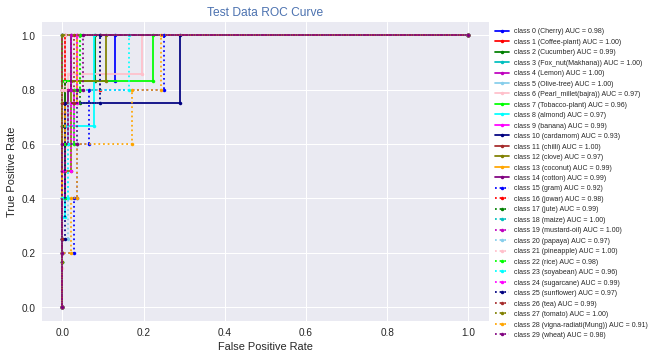

In [34]:
# Plot ROC (Receiver Operating Characteristic) Curve and compute area under curve for each class 
# using test data
import matplotlib as mpl
import seaborn as sms
mpl.style.use('seaborn')
import matplotlib.pyplot as plt
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fig, ax = plt.subplots()
for i, c, l in zip(range(img_class_count), cycle(color_list), line_style_list):
    fpr_, tpr_, _ = roc_curve(testD_noshuffle.labels, test_scores[:, i], pos_label=i)
    auc_ = auc(fpr_, tpr_)
    label_ = 'class ' + str(i) + " (" + labelToNameDict[i] + ") AUC = %0.2f)" % auc_
    plt.plot(fpr_, tpr_, marker='.', label=label_, color = c, linestyle = l)
plt.title("Test Data ROC Curve", color='C6')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.legend(bbox_to_anchor = (1.0,1.0), loc = "upper left", fontsize = "x-small")
#plt.legend()
plt.show()

In [35]:
# Print precision, recall, F-score for each class 
# using test data
from sklearn.metrics import classification_report
scores = classification_report(testD_noshuffle.labels, test_pred_labels)
print(scores)

              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.71      1.00      0.83         5
           2       0.71      0.83      0.77         6
           3       1.00      0.75      0.86         4
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.55      0.86      0.67         7
           7       0.56      0.83      0.67         6
           8       0.67      0.67      0.67         3
           9       0.75      0.60      0.67         5
          10       0.75      0.75      0.75         4
          11       0.80      1.00      0.89         4
          12       0.57      0.67      0.62         6
          13       0.67      0.50      0.57         4
          14       0.75      0.60      0.67         5
          15       0.50      0.20      0.29         5
          16       0.80      0.80      0.80         5
          17       1.00    